In [2]:
from patchify import patchify, unpatchify
# Useful Imports
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os,sys
import io
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow.io as tfio
from glob import glob
import time
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import *
#from keras.layers import *

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_image(filename):
    return mpimg.imread(filename)

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


#Load test images
root_dir = "test_set/"
image_dir = root_dir + "images/"
image_filenames_test = [image_dir + 'test_' + str(i + 1)+'.png' for i in range(50)]

imgs = [load_image(image_filenames_test[i]) for i in range(50)]

n=50

In [4]:
# Divide into patches

patch_size = 16
step_size = 16
img_patches = np.asarray([patchify(imgs[i], (patch_size, patch_size,3),step_size) for i in range(n)])
imgs = np.asarray(imgs)
print("Large image shape is: ", imgs.shape)
print("Patches array shape is: ", img_patches.shape)
print(np.max(imgs))
img_patches = np.squeeze(img_patches,axis = 3)
print("Patches array shape is: ", img_patches.shape)

Large image shape is:  (50, 608, 608, 3)
Patches array shape is:  (50, 38, 38, 1, 16, 16, 3)
1.0
Patches array shape is:  (50, 38, 38, 16, 16, 3)


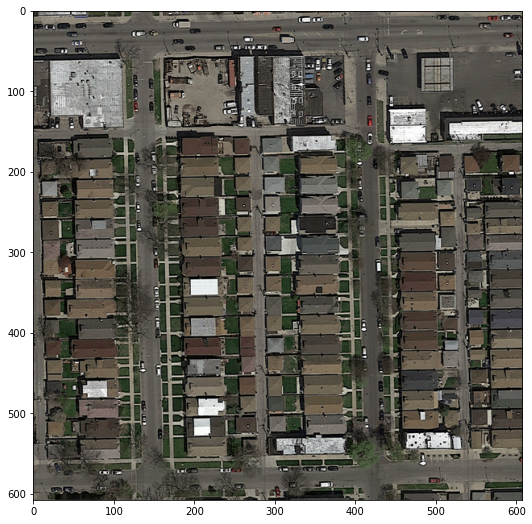

In [5]:
plt.figure(figsize=(9, 9))
plt.imshow(imgs[0], cmap='gray')

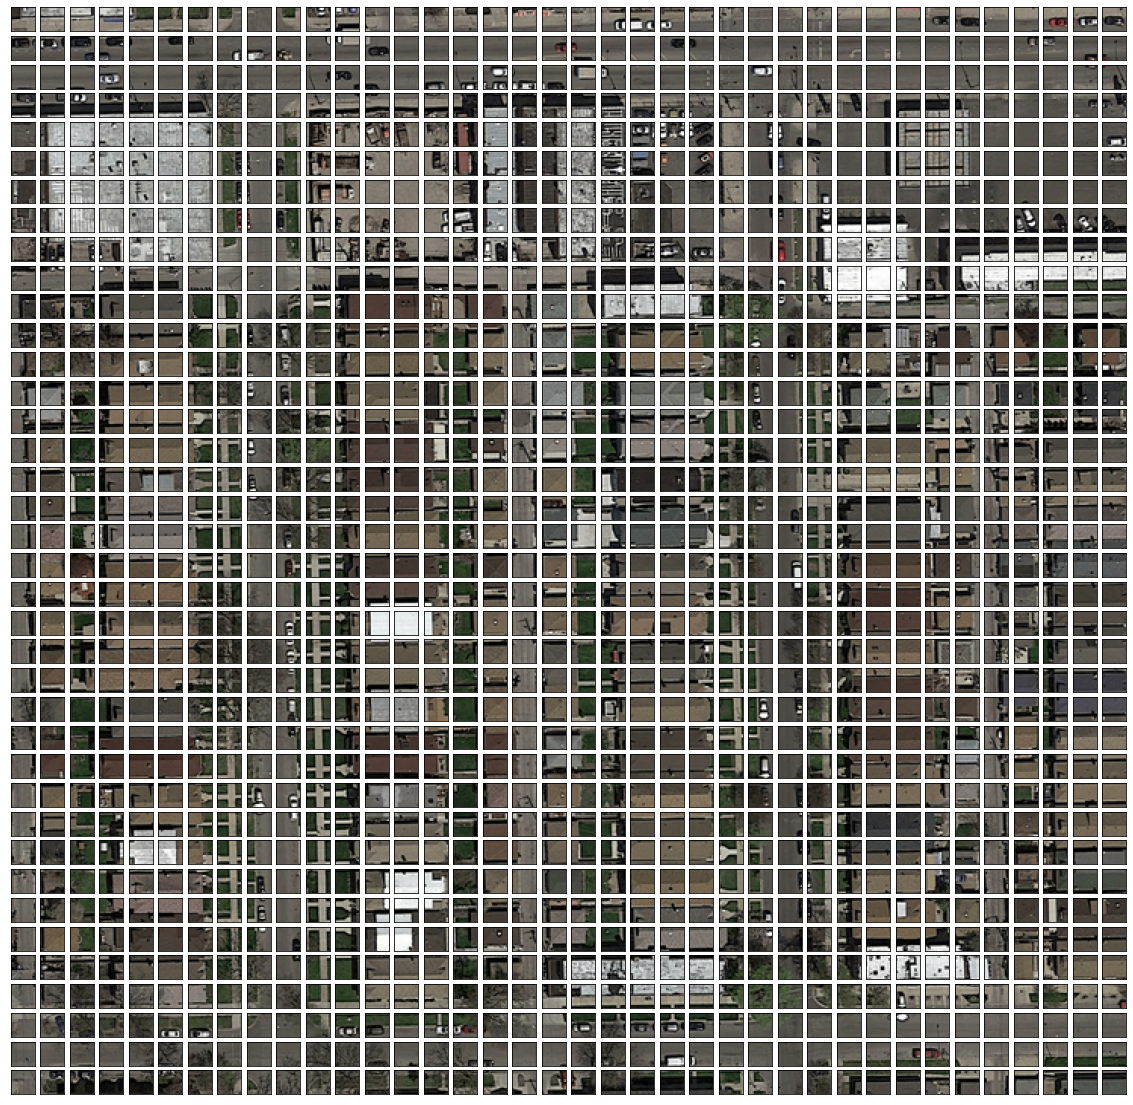

In [7]:
plt.figure(figsize=(20, 20))
square = 38
ix = 1

i=0
for j in range(square):
	for k in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(img_patches[i, j, k, :, :, :])
		ix += 1
# show the figure
plt.show()

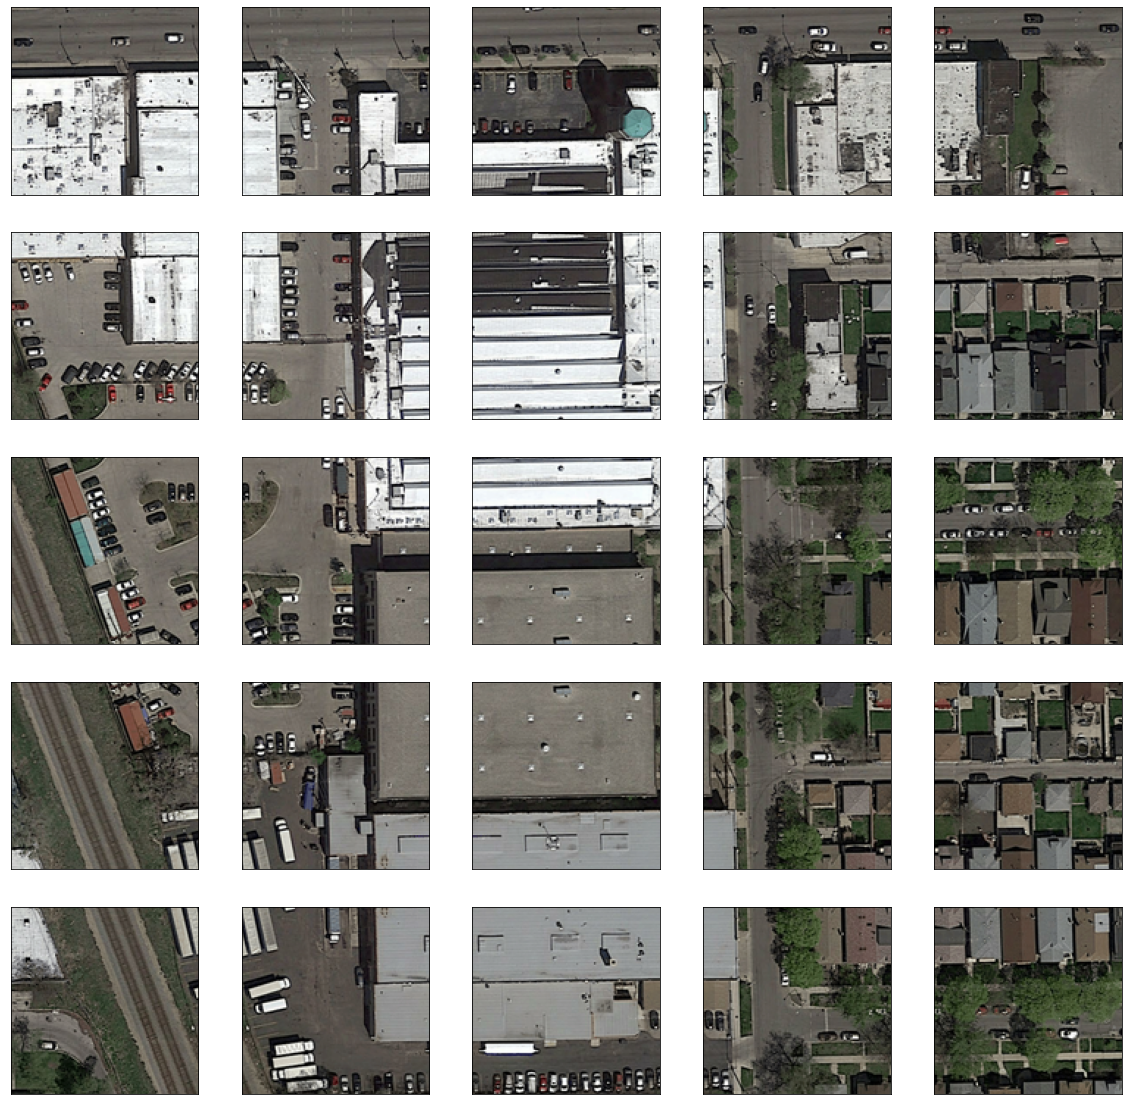

In [112]:
plt.figure(figsize=(20, 20))
square = 5
ix = 1

i=1
for j in range(square):
	for k in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(img_patches[i, j, k, :, :, :])
		ix += 1
# show the figure
plt.show()

In [16]:
print("Image data shape is: ", img_patches.shape)
print("Max pixel value in image is: ", img_patches.max())

Image data shape is:  (50, 5, 5, 128, 128, 3)
Max pixel value in image is:  1.0


In [17]:
#ATTENTION
from keras.models import load_model
model = load_model("Saved_models/unet_128_train.hdf5", compile=False)

In [18]:
#Apply a trained model on large image, patch by patch
img_predict_patch = []


for i in range(img_patches.shape[0]):
    for j in range(img_patches.shape[1]):
        for k in range(img_patches.shape[2]):
            print("Now predicting on patch", i,j,k)
        
            patch = img_patches[i,j,k,:,:,:]  

            
            patch_input=np.expand_dims(patch, 0)
            patch_prediction = model.predict(patch_input)#[0,:,:,0] > 0.5).astype(np.uint8)
            
            img_predict_patch.append(patch_prediction)

img_predict_patch = np.array(img_predict_patch)


Now predicting on patch 0 0 0
Now predicting on patch 0 0 1
Now predicting on patch 0 0 2
Now predicting on patch 0 0 3
Now predicting on patch 0 0 4
Now predicting on patch 0 1 0
Now predicting on patch 0 1 1
Now predicting on patch 0 1 2
Now predicting on patch 0 1 3
Now predicting on patch 0 1 4
Now predicting on patch 0 2 0
Now predicting on patch 0 2 1
Now predicting on patch 0 2 2
Now predicting on patch 0 2 3
Now predicting on patch 0 2 4
Now predicting on patch 0 3 0
Now predicting on patch 0 3 1
Now predicting on patch 0 3 2
Now predicting on patch 0 3 3
Now predicting on patch 0 3 4
Now predicting on patch 0 4 0
Now predicting on patch 0 4 1
Now predicting on patch 0 4 2
Now predicting on patch 0 4 3
Now predicting on patch 0 4 4
Now predicting on patch 1 0 0
Now predicting on patch 1 0 1
Now predicting on patch 1 0 2
Now predicting on patch 1 0 3
Now predicting on patch 1 0 4
Now predicting on patch 1 1 0
Now predicting on patch 1 1 1
Now predicting on patch 1 1 2
Now predic

In [8]:
img_predict_patch = np.reshape(img_predict_patch,(img_patches.shape[0],img_patches.shape[1],img_patches.shape[2], 128,128) )
img_predict_patch.shape

(50, 5, 5, 128, 128)

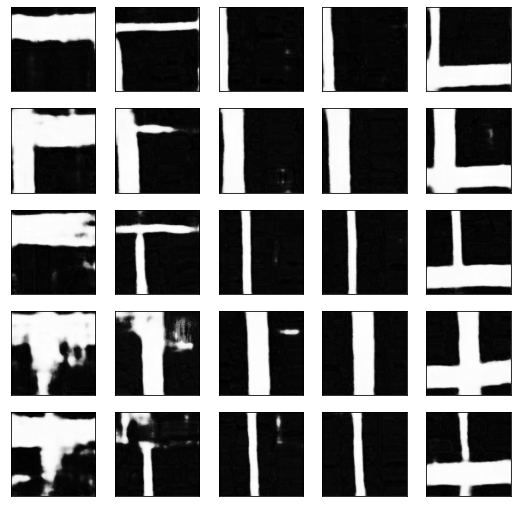

In [117]:
plt.figure(figsize=(9, 9))
square = 5
ix = 1

i=0
for k in range(square):
	for j in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(img_predict_patch[i, j, k, :, :], cmap='Greys_r')
		ix += 1
# show the figure
plt.show()

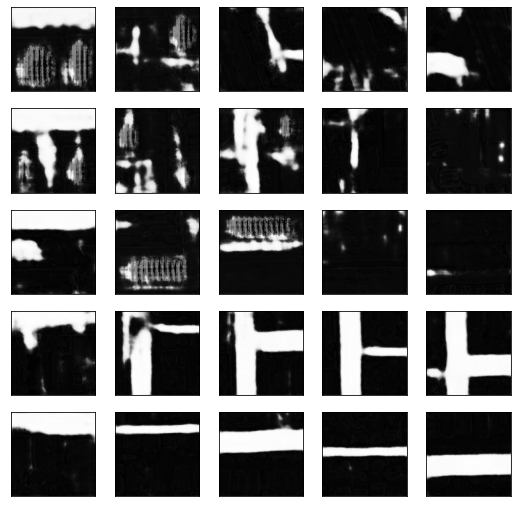

In [118]:
plt.figure(figsize=(9, 9))
square = 5
ix = 1

i=1
for k in range(square):
	for j in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(img_predict_patch[i, j, k, :, :], cmap='Greys_r')
		ix += 1
# show the figure
plt.show()

In [9]:
## Reconstruct full image


reconstructed_img  = np.asarray([unpatchify(img_predict_patch[i],(608,608)) for i in range(n)])
print(reconstructed_img.shape)



(50, 608, 608)


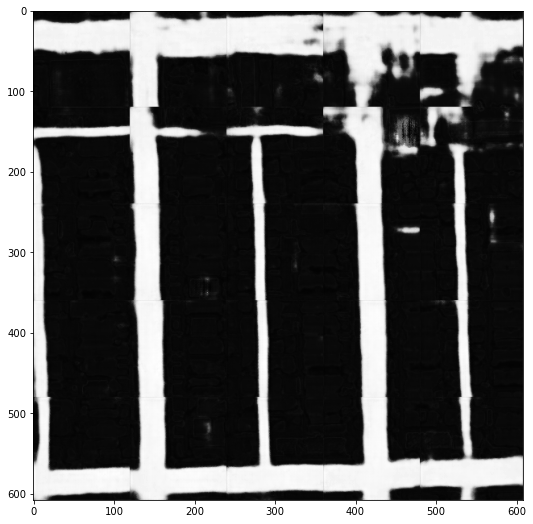

In [120]:
plt.figure(figsize=(9, 9))
plt.imshow(reconstructed_img[0], cmap='gray')

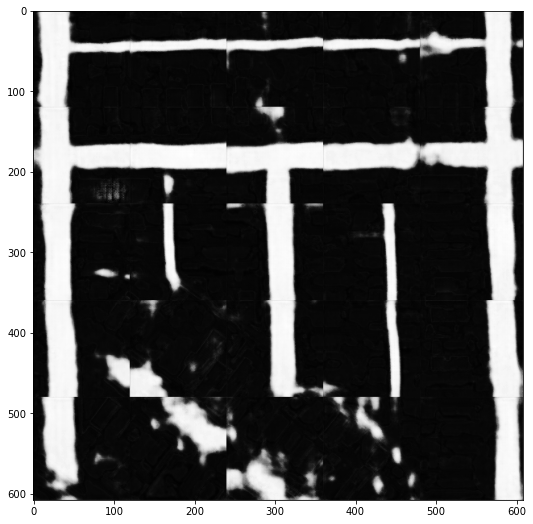

In [121]:
plt.figure(figsize=(9, 9))
plt.imshow(reconstructed_img[9], cmap='gray')

In [16]:
reconstructed_img[0]

array([[0.12421268, 0.10412955, 0.08542439, ..., 0.8859272 , 0.85572505,
        0.6710946 ],
       [0.06484595, 0.0392257 , 0.02627382, ..., 0.95159805, 0.918576  ,
        0.82864803],
       [0.04552683, 0.02755004, 0.02419752, ..., 0.957137  , 0.9417863 ,
        0.8274332 ],
       ...,
       [0.04011378, 0.03668723, 0.03383976, ..., 0.03323269, 0.02476904,
        0.0475283 ],
       [0.04293415, 0.04177266, 0.03490171, ..., 0.0229367 , 0.02682981,
        0.04214898],
       [0.0781469 , 0.06011471, 0.06462657, ..., 0.03587055, 0.04621604,
        0.06696132]], dtype=float32)

In [19]:
# assign a label to a patch
def patch_to_label(patch):
    """Maps a BW white patch image to a label using thresholding """
    df = np.mean(patch)
    if df > FOREGROUND_THRESHOLD:
        return 1
    else:
        return 0
    
FOREGROUND_THRESHOLD  = 0.25 

In [20]:
prediction_path="prediction_unet/"
for i in range(reconstructed_img.shape[0]):
    test1 = np.squeeze(reconstructed_img[i]).round()
    test = img_float_to_uint8(test1)
    prediction_name = prediction_path + 'pred_' + str(i + 1) + '_unet.png'
    Image.fromarray(test).save(prediction_name)

In [21]:
image_filenames_predict = [prediction_path + 'pred_' + str(i + 1) + '_unet.png' for i in range(reconstructed_img.shape[0])]
image_filenames_predict

['prediction_unet/pred_1_unet.png',
 'prediction_unet/pred_2_unet.png',
 'prediction_unet/pred_3_unet.png',
 'prediction_unet/pred_4_unet.png',
 'prediction_unet/pred_5_unet.png',
 'prediction_unet/pred_6_unet.png',
 'prediction_unet/pred_7_unet.png',
 'prediction_unet/pred_8_unet.png',
 'prediction_unet/pred_9_unet.png',
 'prediction_unet/pred_10_unet.png',
 'prediction_unet/pred_11_unet.png',
 'prediction_unet/pred_12_unet.png',
 'prediction_unet/pred_13_unet.png',
 'prediction_unet/pred_14_unet.png',
 'prediction_unet/pred_15_unet.png',
 'prediction_unet/pred_16_unet.png',
 'prediction_unet/pred_17_unet.png',
 'prediction_unet/pred_18_unet.png',
 'prediction_unet/pred_19_unet.png',
 'prediction_unet/pred_20_unet.png',
 'prediction_unet/pred_21_unet.png',
 'prediction_unet/pred_22_unet.png',
 'prediction_unet/pred_23_unet.png',
 'prediction_unet/pred_24_unet.png',
 'prediction_unet/pred_25_unet.png',
 'prediction_unet/pred_26_unet.png',
 'prediction_unet/pred_27_unet.png',
 'predicti

In [22]:
import re
def mask_to_submission_strings_unet(image_filename):
    """Reads a predicted image (BW) and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i: i + patch_size, j: j + patch_size]
            label = patch_to_label(patch)
            yield "{:03d}_{}_{},{}".format(img_number, j, i, label)


In [23]:
def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings_unet(fn))


submission_filename= '\submission_unet.csv'
masks_to_submission(submission_filename, *image_filenames_predict)

(50, 1444, 16, 16)


(50, 1444, 16, 16)
